In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import os

from torchtext import data
from torchtext.data import Dataset
from torchtext.datasets import SequenceTaggingDataset
from sklearn.model_selection import train_test_split


EVENTS_TSV = '/events/tsv/'
ENTITIES_TSV = '/entities/tsv/'

class DataLoader:
    def __init__(self):
        self.entities_files = [file.split('.')[0] for file in os.listdir(ENTITIES_TSV)]
        self.events_files = [file.split('.')[0] for file in os.listdir(EVENTS_TSV)]
        
        self.all_entities = self._tsv_parser(ENTITIES_TSV, self.entities_files)
        self.all_events = self._tsv_parser(EVENTS_TSV, self.events_files)
        
        entities_tags = set([t for row in self.all_entities[1] for t in row])
        
        self.entities_tag2index = {t : num for num, t in enumerate(entities_tags)}
        self.entities_index2tag = {v : k for k, v in self.entities_tag2index.items()}
        
        self.text_vocab = None
        self.id2text_vocab = None

        self.events_tag_vocab = None
        self.events_dataset = self._get_dataset(EVENTS_TSV, self.events_files, dataset='events')

        self.entities_tag_vocab = None
        self.entities_dataset = self._get_dataset(ENTITIES_TSV, self.entities_files, dataset='entities')

        self.char2index = {w : num + 1 for num, w in enumerate(set(''.join(self.all_entities[0])))}
        self.index2char = {v : k for k, v in self.char2index.items()}
        self.char2index['#'] = 0
        self.index2char[0] = '#'
    
    
    def _tsv_parser(self, path, files):
        words = []
        tags = []
        
        for file in files:
            for row in open(path + file + '.tsv').read().splitlines():
                if row == '':
                    continue

                words.append(row.lower().split()[0])
                
                if path.split('/')[1] == 'events':
                    tags.append(row.split()[1])
                else:
                    tags.append(row.split()[1:])
                
        return words, tags
    
    
    def get_train_val_test_entities(self, val_size=0.5, test_size=0.2, random_state=42):
        train, test = train_test_split(self.entities_files,
                                       test_size=test_size,
                                       random_state=random_state)
        
        val, test = train_test_split(train,
                                      test_size=val_size,
                                      random_state=random_state)

        return self._tsv_parser(ENTITIES_TSV, train), \
               self._tsv_parser(ENTITIES_TSV, val), \
               self._tsv_parser(ENTITIES_TSV, test)
    
    
    def _get_dataset(self, path, files, dataset='events'):
        sentence_field = data.Field(init_token = "<sos>", eos_token = "<eos>", lower=True)
        tag_field = data.Field(init_token = "<sos>", eos_token = "<eos>", is_target=True)
        fields=(('sentence', sentence_field), ('tags', tag_field))

        examples = None

        for file in files:
            std = SequenceTaggingDataset(path=path + file + '.tsv', fields=fields)

            if examples == None:
                examples = std.examples
            else:
                examples += std.examples

        dataset = Dataset(examples, fields=fields)
        
        sentence_field.build_vocab(dataset)
        tag_field.build_vocab(dataset)
        
        self.text_vocab = sentence_field.vocab
        self.id2text_vocab = {i : word for i, word in enumerate(self.text_vocab.itos)}

        if dataset == 'events':
            self.events_tag_vocab = tag_field.vocab
        else:
          self.entities_tag_vocab = tag_field.vocab
        
        return dataset


    def get_train_val_test(self, dataset='events', train_size=0.8, val_size=0.5):
        if dataset == 'events':
            train, test = self.events_dataset.split(split_ratio=train_size)
        else:
            train, test = self.entities_dataset.split(split_ratio=train_size)
        val, test = test.split(split_ratio=val_size)
        return train, val, test

In [0]:
dl = DataLoader()

In [0]:
from torchtext.data import BucketIterator

def get_sentences(data, n_sentences):
    sentences, tags = [], []
    
    for num, sentence in enumerate(tqdm(data[0])):
        sentence_tensor = torch.LongTensor([dl.word2index[w] for w in sentence])
        sentences.append(autograd.Variable(sentence_tensor))
        
        tag_tensor = torch.LongTensor([dl.events_tag2index[t] for t in data[1][num]])
        tags.append(autograd.Variable(tag_tensor))
        
        if len(sentences) == n_sentences:
            yield torch.cat(sentences), torch.cat(tags)
            sentences, tags = [], []
            
def get_batches(data, batch_size):
    return BucketIterator(data, \
                          batch_size=batch_size, \
                          sort_key=lambda x: data.interleave_keys(len(x.sentence), len(x.tag)), \
                          shuffle=True \
                         )

## 2.1

Реализуем архитектуру *CNN-BiLSTM-CRF* для извлечения именованных сущностей, то есть каждому слову сопоставляем один из возможных тэгов.

Архитектура состоит из трех частей: 
1. *CNN* на символах
2. *BiLSTM* на объединении эмбеддингов слов и признаков из *CNN*
3. *CRF* на выходе(логитах) из полносвязного слоя для подсчета условных вероятностей появления классов(например, учитывать, что вероятность тэга I-...(Inside) после тэга O(out) была минимальной)

Загрузим данные для датасета именованных сущностей.

In [0]:
train_data, val_data, test_data = dl.get_train_val_test(dataset='entities', train_size=0.8, val_size=0.5)

Реализуем вспомогательные функции для подготовки датасета. Здесь данные будут иметь иной от следующих пунктов вид, так как для *CNN* необходимо символьное представление слов(то есть слова в виде набора индексов символов из словаря). 


*sentance_to_char_matrix* переводит предложение в матрицу, в которой каждая строка соответсвует слову из предложения, а по столбцам располагаются индексы символов из словаря.

*get_cnn_loader* формирует батчи, в каждый из которых входит *batch_size* предложений. Зададим количество предложений в батче = 32.

In [0]:
import numpy as np

def sentance_to_char_matrix(words, max_len=None, pad=dl.char2index['#'], dtype=np.int64):
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        word_ix = list(map(dl.char2index.get, words[i]))
        words_ix[i, :len(word_ix)] = word_ix

    word_ids = []
    tensor_words = []
    for i in range(len(words)):
        tensor_words.append(torch.tensor(words_ix[i]))
        word_ids.append(dl.text_vocab.stoi[words[i]])

    return tuple((torch.tensor(word_ids), tensor_words))


def get_cnn_loader(data, batch_size=32):
    indexes = np.random.permutation(len(data))
    num_batches = len(indexes) // batch_size

    batches = []
    batch_data = []
    batch_targets = []

    for i in range(len(indexes)):
        if i % batch_size == 0 and i != 0:
            batches.append(tuple((sentance_to_char_matrix(batch_data), batch_targets)))
            batch_data = []
            batch_targets = []

        batch_data.extend(data[indexes[i]].sentence)
        batch_targets.extend(map(lambda x: dl.entities_tag2index[x],
                          data[indexes[i]].tags))
    return batches

Сформируем загрузчики батчей.

In [0]:
cnn_train_loader = get_cnn_loader(train_data)
cnn_val_loader = get_cnn_loader(val_data)
cnn_test_loader = get_cnn_loader(test_data)

Воспользуемся реализацией *CRF* из https://pytorch-crf.readthedocs.io/en/stable/#getting-started.

In [60]:
!pip install pytorch-crf

Опишем архитектуру.

Модель принимает предложения в двух видах: матрица символов и набор идексов слов из словаря.

Матрицу символов обрабатывает *CNN*. Получает обобщенное представление слова, используя свертки разного размера, что позволяет избежать незначительных грамматических ошибок. Далее выход *CNN* объединяется с эмбеддингами слов и подается на вход *BiLSTM* слою. На выходе получаем логиты при помощи *log_softmax* из полносвязного слоя. Далее применяем *CRF* для нормализации предсказаний.  

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch
from torchcrf import CRF

class CNN_BILSTM(nn.Module):
    def __init__(self, ch_vocab_size, char_embedding_dim, word_embedding_dim, word_vocab_size, n_filters, 
                 filter_sizes, dropout, hidden_dim, output_cnn_dim=30, num_classes=13):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        self.char_embedding = nn.Embedding(ch_vocab_size, char_embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, 
                                              kernel_size=(size, char_embedding_dim)) for size in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_cnn_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        
        self.lstm = nn.LSTM(word_embedding_dim + output_cnn_dim, 
                            self.hidden_dim // 2, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(self.hidden_dim, num_classes)
        
        self.hidden = self.init_hidden()

        self.CRF = CRF(num_classes, batch_first=True)
        
    def init_hidden(self):
        return (autograd.Variable(torch.zeros(2, 1, self.hidden_dim // 2)),
                autograd.Variable(torch.zeros(2, 1, self.hidden_dim // 2)))
        
    def forward(self, input):
        out_cnn = []
        
        for x in input[1]:
            x = x.view(1, -1)
            char_embedded = self.char_embedding(x)
            char_embedded = char_embedded.unsqueeze(1)
            conved = [F.relu(conv(char_embedded)).squeeze(3) for conv in self.convs]
            pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
            char_cat = self.dropout(torch.cat((pooled), dim=1))
            out_cnn.append(char_cat)
            
        out_cnn = torch.cat(out_cnn, dim=0)
        fin_cat = torch.cat((self.word_embedding(input[0]), out_cnn), 1)
        char_cat = fin_cat.unsqueeze(1)
        char_cat = self.dropout(char_cat)

        lstm_out, _ = self.lstm(char_cat)
        lstm_out = lstm_out.view(len(input[0]), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        
        out = F.log_softmax(lstm_feats)
        return out

Функции тренировки, валидации и отрисовки графиков:
Оценивать будем по *f1* мере.
Лосс подсчитвается в *CRF*.

In [0]:
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.optim as optim
from sklearn.metrics import f1_score


def train_epoch(model, optimazer):
    loss_log, acc_log = [], []
    step = 0
    
    model.train(True)

    for batch in tqdm(cnn_train_loader):   
        data = batch[0]
        target = batch[1]

        optimazer.zero_grad()
        model.hidden = model.init_hidden()

        output = model(data)
        loss = -model.CRF(output.unsqueeze(1), torch.tensor(target).unsqueeze(1)) / len(data[0])
        
        acc = f1_score(model.CRF.decode(output.unsqueeze(1)), 
                       target, average='macro').mean()
        acc_log.append(acc.item())

        loss.backward()
        optimazer.step()
        loss_log.append(loss.item())
        step += 1
    return loss_log, acc_log, step
        
    
def test(model, criterion):
    loss_log, acc_log = [], []
    model.eval()

    for batch in tqdm(cnn_val_loader):   
        data = batch[0]
        target = batch[1]

        output = model(data)
        loss = -model.CRF(output.unsqueeze(1), torch.tensor(target).unsqueeze(1)) / len(data[0])
        
        acc = f1_score(model.CRF.decode(output.unsqueeze(1)), 
                       target, average='macro').mean()
        acc_log.append(acc.item())
        
        loss_log.append(loss.item())
        
    return loss_log, acc_log

    
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
    
def train(model, optimazer, n_epochs=15):
    train_loss_log, train_acc_log = [], []
    val_loss_log, val_acc_log = [], []
    
    for epoch in range(n_epochs):
        print('Epoch {0} of {1}'.format(epoch, n_epochs))
        
        train_loss, train_acc, step = train_epoch(model, optimazer, criterion)
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss, val_acc = test(model, criterion)
        print(val_loss)
        val_loss_log.append((step * (epoch + 1), np.mean(val_loss)))
        print(val_acc)
        val_acc_log.append((step * (epoch + 1), np.mean(val_acc)))
        
        clear_output()
        plot_history(train_loss_log, val_loss_log)
        plot_history(train_acc_log, val_acc_log, title='accuracy')

        print("Epoch: {0}, val loss: {1}, val accuracy: {2}".format(epoch, 
                                                                    np.mean(val_loss), np.mean(val_acc)))

Запустим обучение с двумя окнами(размером 2 и 3) и 15 фильтрами в *CNN* на 15 эпохах.

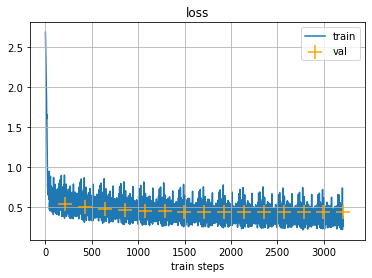

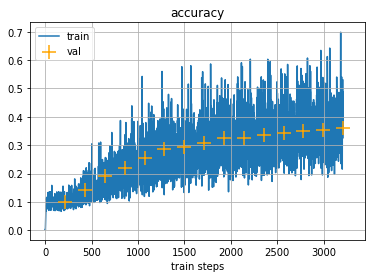

Epoch: 14, val loss: 0.43374539338625395, val accuracy: 0.35952607826151783
CPU times: user 56min 59s, sys: 5min 12s, total: 1h 2min 12s
Wall time: 1h 2min 30s


In [82]:
import torch.optim as optim

CHAR_VOCAB_DIM = len(dl.char2index)
WORD_VOCAB_DIM = len(dl.text_vocab.stoi)
W_EMBEDDING_DIM = 200
CH_EMBEDDING_DIM = 30
HIDDEN_DIM = 230
N_FILTERS = 15
FILTER_SIZES = [2, 3]
DROPOUT = 0.5
N_EPOCHS = 15


model = CNN_BILSTM(CHAR_VOCAB_DIM, CH_EMBEDDING_DIM, W_EMBEDDING_DIM, 
                   WORD_VOCAB_DIM, N_FILTERS, FILTER_SIZES,
                   DROPOUT, HIDDEN_DIM)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

%time train(model, optimizer, n_epochs=15)


Получили качество на валидации ~0.35.